## **Import package**


In [171]:
import torch
import numpy as np
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## **Check null data**


In [172]:
train_data = pd.read_csv("./train.csv")
test_data = pd.read_csv("./test.csv")
gender_submission = pd.read_csv("./gender_submission.csv")

print(train_data.shape)
# Age, Cabin, Embarked有缺少值
# train_data.info()
# Age, Fare, Cabin有缺少值
# test_data.info()

(891, 12)


## **Combine data to Analysis**


In [173]:
data = train_data.append(test_data)
# index 重疊
data.reset_index(inplace=True, drop=True)
data.head()

/var/folders/xy/_w9xgnh50vx3yskdhjmwlzy40000gn/T/ipykernel_95302/2478461588.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = train_data.append(test_data)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<Axes: xlabel='Survived', ylabel='count'>

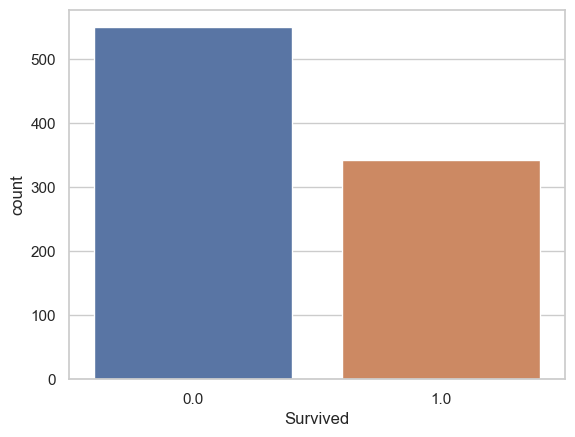

In [174]:
sns.countplot(x="Survived", data=data)

<Axes: xlabel='Pclass', ylabel='count'>

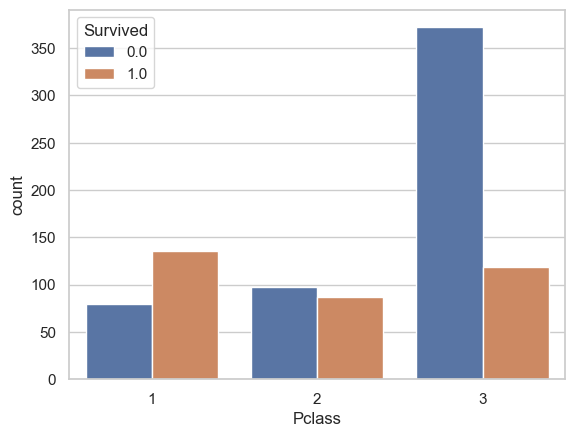

In [175]:
# 坐class3的死亡率高
sns.countplot(x="Pclass", hue="Survived", data=data)

<Axes: xlabel='Sex', ylabel='count'>

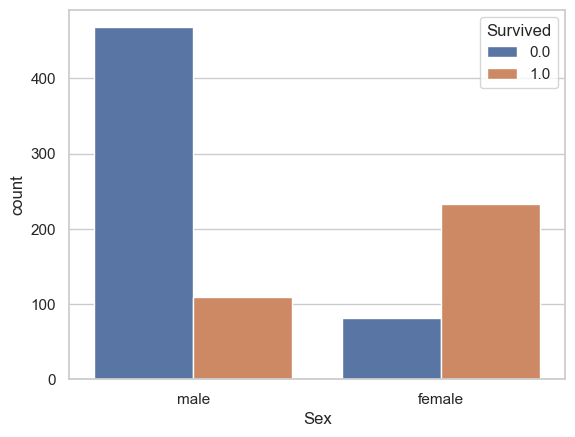

In [176]:
# 女生存活率高
sns.countplot(x="Sex", hue="Survived", data=data)

<Axes: xlabel='Embarked', ylabel='count'>

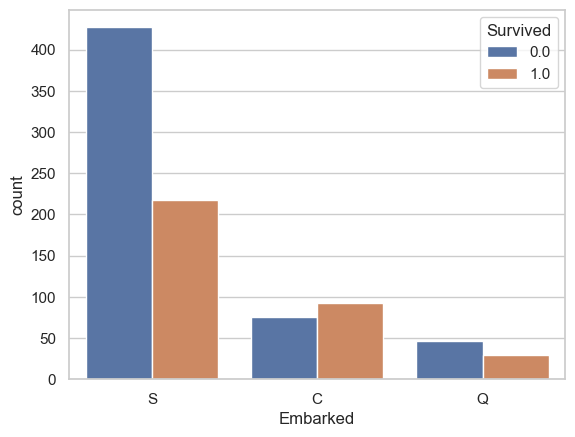

In [177]:
# 從S港出發的死亡率高
sns.countplot(x="Embarked", hue="Survived", data=data)

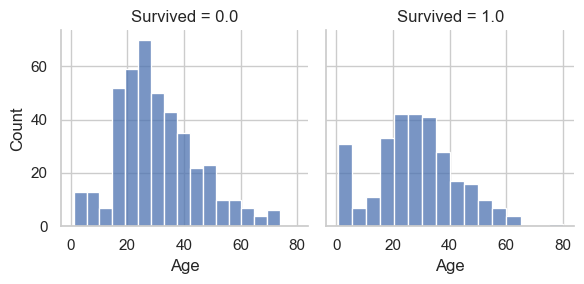

In [178]:
# 小孩存活率高
g = sns.FacetGrid(data, col='Survived')
g.map(sns.histplot, 'Age')

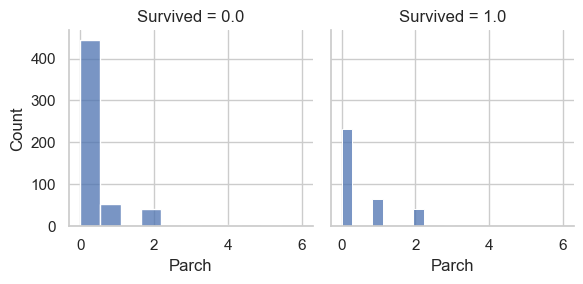

In [179]:
# 有父母陪伴的存活率高
g = sns.FacetGrid(data, col='Survived')
g.map(sns.histplot, 'Parch')

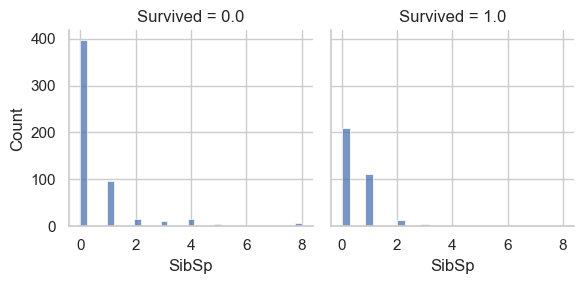

In [180]:
# 有親屬的存活率高
g = sns.FacetGrid(data, col='Survived')
g.map(sns.histplot, 'SibSp')

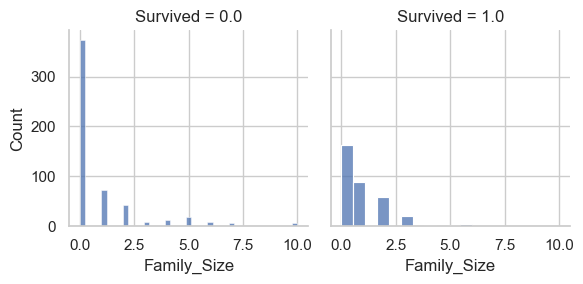

In [181]:
data['Family_Size'] = data['Parch']+data['SibSp']
g = sns.FacetGrid(data, col='Survived')
g.map(sns.histplot, 'Family_Size')

## **Feature Engineering**


In [182]:
data['Title1'] = data['Name'].str.split(", ", expand=True)[1]
data['Name'].str.split(", ", expand=True).head()

,0,1
0,Braund,Mr. Owen Harris
1,Cumings,Mrs. John Bradley (Florence Briggs Thayer)
2,Heikkinen,Miss. Laina
3,Futrelle,Mrs. Jacques Heath (Lily May Peel)
4,Allen,Mr. William Henry


In [183]:
data['Title1'] = data['Title1'].str.split(". ", expand=True)[0]
data['Title1'].head()
data['Title1'].unique()

pd.crosstab(data["Title1"], data["Sex"]
            ).T.style.background_gradient(cmap="summer_r")

Title1,Capt,Col,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,th
Sex,,,,,,,,,,,,,,,,,,
female,0,0,0,1,1,0,1,0,0,260,2,1,0,197,2,0,0,1
male,1,4,1,0,7,1,0,2,61,0,0,0,757,0,0,8,1,0


In [184]:
pd.crosstab(data["Title1"], data["Survived"]
            ).T.style.background_gradient(cmap="summer_r")

Title1,Capt,Col,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,th
Survived,,,,,,,,,,,,,,,,,
0.000000,1,1,1,4,1,0,1,17,55,0,0,436,26,0,6,0,0
1.000000,0,1,0,3,0,1,1,23,127,2,1,81,99,1,0,1,1


In [185]:
data.groupby(['Title1'])['Age'].mean()

Title1
Capt        70.000000
Col         54.000000
Don         40.000000
Dona        39.000000
Dr          43.571429
Jonkheer    38.000000
Lady        48.000000
Major       48.500000
Master       5.482642
Miss        21.774238
Mlle        24.000000
Mme         24.000000
Mr          32.252151
Mrs         36.994118
Ms          28.000000
Rev         41.250000
Sir         49.000000
th          33.000000
Name: Age, dtype: float64

In [186]:
name_mapping = {
    'Mr': 'Mr',
    'Mrs': 'Mrs',
    'Miss': 'Miss',
    'Master': 'Master',
    'Don': 'Mr',
    'Rev': 'Mr',
    'Dr': 'Mr',
    'Mme': 'Mrs',
    'Ms': 'Miss',
    'Major': 'Mr',
    'Lady': 'Mrs',
    'Sir': 'Mr',
    'Mlle': 'Miss',
    'Col': 'Mr',
    'Capt': 'Mr',
    'the Countess': 'Mrs',
    'Jonkheer': 'Mr',
    'Dona': 'Miss',
    'th': "Mr"
}
data['Title2'] = data['Title1'].replace(name_mapping)
data['Title2'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master'], dtype=object)

In [187]:
pd.crosstab(data["Title2"], data["Sex"]
            ).T.style.background_gradient(cmap="summer_r")

Title2,Master,Miss,Mr,Mrs
Sex,,,,
female,0,265,2,199
male,61,0,782,0


In [188]:
pd.crosstab(data["Title2"], data["Survived"]
            ).T.style.background_gradient(cmap="summer_r")

Title2,Master,Miss,Mr,Mrs
Survived,,,,
0.000000,17,55,451,26
1.000000,23,130,88,101


In [189]:
data['Ticket_info'] = data['Ticket'].apply(lambda x: x.replace(
    ".", "").replace("/", "").strip().split(' ')[0] if not x.isdigit() else 'X')


data["Ticket_info"].unique()

array(['A5', 'PC', 'STONO2', 'X', 'PP', 'CA', 'SCParis', 'SCA4', 'A4',
       'SP', 'SOC', 'WC', 'SOTONOQ', 'WEP', 'STONO', 'C', 'SCPARIS',
       'SOP', 'Fa', 'LINE', 'FCC', 'SWPP', 'SCOW', 'PPP', 'SC', 'SCAH',
       'AS', 'SOPP', 'FC', 'SOTONO2', 'CASOTON', 'SCA3', 'STONOQ', 'AQ4',
       'A', 'LP', 'AQ3'], dtype=object)

## **Fill null value**


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Size,Title1,Title2,Ticket_info
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NoCabin,S,1,Mr,Mr,A5
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,1,Mrs,Mrs,PC
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NoCabin,S,0,Miss,Miss,STONO2
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,1,Mrs,Mrs,X
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NoCabin,S,0,Mr,Mr,X


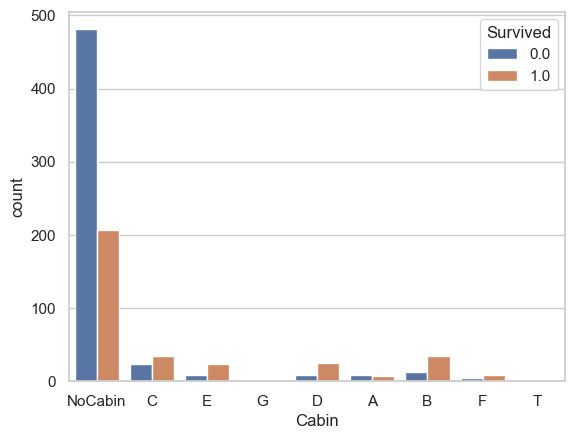

In [190]:
data['Embarked'] = data['Embarked'].fillna("S")
data['Fare'] = data['Fare'].fillna(data['Fare'].mean())
data['Cabin'] = data['Cabin'].apply(
    lambda x: str(x)[0] if not pd.isnull(x) else 'NoCabin')
sns.countplot(x='Cabin', hue='Survived', data=data)
data.head()

In [191]:
data['Sex'] = data['Sex'].astype('category').cat.codes
data['Embarked'] = data['Embarked'].astype('category').cat.codes
data['Pclass'] = data['Pclass'].astype('category').cat.codes
data['Title1'] = data['Title1'].astype('category').cat.codes
data['Title2'] = data['Title2'].astype('category').cat.codes
data['Cabin'] = data['Cabin'].astype('category').cat.codes
data['Ticket_info'] = data['Ticket_info'].astype('category').cat.codes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int8   
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   int8   
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Cabin        1309 non-null   int8   
 11  Embarked     1309 non-null   int8   
 12  Family_Size  1309 non-null   int64  
 13  Title1       1309 non-null   int8   
 14  Title2       1309 non-null   int8   
 15  Ticket_info  1309 non-null   int8   
dtypes: float64(3), int64(4), int8(7), object(2)
memory usage: 101.1+ KB


In [192]:
# 從數據集中選擇所有年齡（Age）為空的行
dataAgeNull = data[data["Age"].isnull()]

# 從數據集中選擇所有年齡（Age）不為空的行
dataAgeNotNull = data[data["Age"].notnull()]

# 刪除異常值：選擇票價（Fare）和家庭大小（Family_Size）超過平均值的四倍標準差的行
remove_outlier = dataAgeNotNull[
    (np.abs(dataAgeNotNull["Fare"] - dataAgeNotNull["Fare"].mean()) > (4 * dataAgeNotNull["Fare"].std())) |
    (np.abs(dataAgeNotNull["Family_Size"] - dataAgeNotNull["Family_Size"].mean())
     > (4 * dataAgeNotNull["Family_Size"].std()))
]

# 創建隨機森林回歸模型，使用2000棵樹，隨機種子為42
rfModel_age = RandomForestRegressor(n_estimators=2000, random_state=42)

# 選擇特徵列，這些特徵將用於預測年齡
ageColumns = ['Embarked', 'Fare', 'Pclass', 'Sex',
              'Family_Size', 'Title1', 'Title2', 'Cabin', 'Ticket_info']

# 使用非異常值行的數據訓練隨機森林模型，預測年齡
rfModel_age.fit(remove_outlier[ageColumns], remove_outlier["Age"])

# 使用隨機森林模型預測年齡缺失值
ageNullValues = rfModel_age.predict(X=dataAgeNull[ageColumns])

# 將預測的年齡值填充回缺失值的行
dataAgeNull.loc[:, "Age"] = ageNullValues

# 將填充後的有年齡值的行和原始的非缺失年齡行合併
data = dataAgeNull.append(dataAgeNotNull)

# 重新設置索引，並將舊的索引丟棄
data.reset_index(inplace=True, drop=True)

/var/folders/xy/_w9xgnh50vx3yskdhjmwlzy40000gn/T/ipykernel_95302/1346844122.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataAgeNull.loc[:, "Age"] = ageNullValues
/var/folders/xy/_w9xgnh50vx3yskdhjmwlzy40000gn/T/ipykernel_95302/1346844122.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = dataAgeNull.append(dataAgeNotNull)


In [193]:
# 從處理後的數據集中選擇生存（Survived）列不為空的行，並按照乘客ID（PassengerId）進行排序
dataTrain = data[pd.notnull(data['Survived'])].sort_values(by=["PassengerId"])

# 從處理後的數據集中選擇生存（Survived）列為空的行，並按照乘客ID（PassengerId）進行排序
dataTest = data[~pd.notnull(data['Survived'])].sort_values(by=["PassengerId"])

dataTrain.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Size,Title1,Title2,Ticket_info
263,1,0.0,2,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,7,2,1,12,2,2
264,2,1.0,0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,2,0,1,13,3,14
265,3,1.0,2,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,7,2,0,9,1,31
266,4,1.0,0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2,2,1,13,3,36
267,5,0.0,2,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,7,2,0,12,2,36


In [194]:
dataTrain = dataTrain[['Survived', 'Age', 'Embarked', 'Fare',
                       'Pclass', 'Sex', 'Family_Size', 'Title2', 'Ticket_info', 'Cabin']]
dataTest = dataTest[['Age', 'Embarked', 'Fare', 'Pclass',
                     'Sex', 'Family_Size', 'Title2', 'Ticket_info', 'Cabin']]

In [195]:
# 從 sklearn 中導入隨機森林分類器
from sklearn.ensemble import RandomForestClassifier

# 創建隨機森林分類器，設置了一些參數
rf = RandomForestClassifier(criterion='gini',        # 使用 Gini 不純度來衡量分類效果
                            n_estimators=1000,       # 使用1000棵樹
                            min_samples_split=12,    # 最小分割樣本數為12
                            min_samples_leaf=1,      # 最小葉子樣本數為1
                            oob_score=True,          # 啟用 out-of-bag 評估
                            random_state=1,          # 隨機種子設置為1，確保可重現性
                            n_jobs=-1)               # 使用所有可用核心進行訓練

# 使用訓練集進行模型訓練，其中 dataTrain.iloc[:, 1:] 表示特徵部分，dataTrain.iloc[:, 0] 表示目標（Survived）
rf.fit(dataTrain.iloc[:, 1:], dataTrain.iloc[:, 0])

# 輸出 out-of-bag 評估分數
print("%.4f" % rf.oob_score_)

# 使用 pd.concat 函式，將特徵名稱和其對應的重要性值合併在一起，形成一個 DataFrame
# dataTrain.iloc[:, 1:].columns 是訓練集的特徵名稱
# pd.DataFrame(rf.feature_importances_, columns = ['importance']) 是隨機森林模型的特徵重要性值
# axis = 1 表示在水平方向上合併 DataFrame
merged_data = pd.concat((pd.DataFrame(dataTrain.iloc[:, 1:].columns, columns=['variable']),
                         pd.DataFrame(rf.feature_importances_, columns=['importance'])),
                        axis=1)

# 使用 sort_values 函式，根據重要性值（importance）遞減排序，並選取前 20 個
top_20_features = merged_data.sort_values(
    by='importance', ascending=False)[:20]

# 輸出前 20 個最重要的特徵
print(top_20_features)

0.8305
      variable  importance
4          Sex    0.266825
2         Fare    0.163941
6       Title2    0.150056
0          Age    0.132715
3       Pclass    0.090884
5  Family_Size    0.071406
8        Cabin    0.066996
7  Ticket_info    0.031590
1     Embarked    0.025586


In [196]:
rf_res = rf.predict(dataTest)
gender_submission['Survived'] = rf_res
gender_submission['Survived'] = gender_submission['Survived'].astype(int)
gender_submission.to_csv('submit.csv', index=False)

NameError: name 'submit' is not defined